# Compare 3 algorithms

### Create graph class

In [217]:
import matplotlib.pyplot as plt
import networkx as nx

from collections import deque, namedtuple


# we'll use infinity as a default distance to nodes.
inf = float('inf')
Edge = namedtuple('Edge', 'start, end, cost')

class Graph:
    def __init__(self):
        self.edges = []
        self.nxGraph = nx.DiGraph()

    @property
    def vertices(self):
        return set(
            sum(
                ([edge.start, edge.end] for edge in self.edges), []
            )
        )

    
    def get_node_pairs(self, n1, n2):
        return [[n1, n2], [n2, n1]]
            
    def add_edge(self, n1, n2, cost=1):
        node_pairs = self.get_node_pairs(n1, n2)
        for edge in self.edges:
            if [edge.start, edge.end] in node_pairs:
                return ValueError('Edge {} {} already exists'.format(n1, n2))

        self.edges.append(Edge(start=n1, end=n2, cost=cost))
        self.nxGraph.add_edge(n1, n2, weight=abs(cost))

    @property
    def neighbours(self): # can be called adjacency matrix
        neighbours = {vertex: set() for vertex in self.vertices}
        
        for edge in self.edges:
            neighbours[edge.start].add((edge.end, edge.cost))
        return neighbours
    
    def initialize(self,source):
        distances = {}
        previous_vertices = {}
        
        for vertex in self.vertices:
            distances[vertex] = inf
        
        for vertex in self.vertices:
            previous_vertices[vertex] = None 
        distances[source] = 0 # seed the start to the visited list
        
        return distances, previous_vertices  
    
    def relax(self, node, distances, previous_vertices, neighbours):
        for neighbour, cost in neighbours[node]:
            alternative_route = distances[node] + cost
            # If the distance between the node and the neighbour is lower than the one in memo
            if  alternative_route < distances[neighbour]: #update closest table
                distances[neighbour] = alternative_route
                previous_vertices[neighbour] = node
        
    def dijkstra(self, source, dest):
         # Step 1: Prepare the distance and predecessor (previous_vertices) for each node
        distances, previous_vertices = self.initialize(source)
        
        vertices = self.vertices.copy() # using a copy so we dont have to mark visited vertex
        neighbours = self.neighbours # a dictionary of all neighbours
        
        # Step 2: Relax the edges
        while vertices: # loop through all vertices
            # find the vertex that closest
            current_vertex = min(
                vertices, key=lambda vertex: distances[vertex])
            vertices.remove(current_vertex)
            
            if distances[current_vertex] == inf: # unreachable
                break
            
            self.relax(current_vertex, distances, previous_vertices, neighbours)
        print "distances", distances
        print "previous_vertices", previous_vertices 
        
#         Step 3: get the shortest path
        path, current_vertex = deque(), dest
        while previous_vertices[current_vertex] is not None:
            path.appendleft(current_vertex)
            current_vertex = previous_vertices[current_vertex]
        if path:
            path.appendleft(current_vertex)
        return list(path)
    
    def bellman_ford(self, source, dest):
        # Step 1: Prepare the distance and predecessor (previous_vertices) for each node
        distances, previous_vertices = self.initialize(source)
            
        vertices = self.vertices.copy() # not necessary in this algorithm, but it gives us a shorthand
        neighbours = self.neighbours # a dictionary of all neighbours
        
        # Step 2: Relax the edges
#         for i in range(vertices.length -1):
        list_vertices = list(vertices) 
        for v_index in range(len(list_vertices)-1): # loop through all vertices
            self.relax(list_vertices[v_index], distances, previous_vertices, neighbours)       
        
        print "distances", distances
        print "previous_vertices", previous_vertices 
        
        # Step 3: Check for negative weight cycles
        for start, end, cost in self.edges:
            if distances[start] + cost < distances[end]:
                print "Graph contains negative weight cycle at", start, end
                return []
       
        # Step 4: get the shortest path
        path, current_vertex = deque(), dest
        while previous_vertices[current_vertex] is not None:
            path.appendleft(current_vertex)
            current_vertex = previous_vertices[current_vertex]
        if path:
            path.appendleft(current_vertex)
        return list(path)

    def floyd_warshall(self, source, dest):
        # Step 1: Prepare the distance and predecessor matrix
        distance = {}
        next_step = {}

        for i in self.vertices:
            distance[i] = {}
            next_step[i] = {}
            for j in self.vertices:
                distance[i][j]= inf
                next_step[i][j] = None
                for start, end, cost in self.edges: 
                    if(start == i and end == j):
                        distance[i][j]=cost
                        next_step[i][j]=j
                    
        # Step 2: Update the distance and predecessor matrix    
        for k in self.vertices:
            for i in self.vertices:
                 for j in self.vertices:
                        if distance[i][k] == inf or distance[k][j] == inf:
                            continue # unreachable
                        if distance[i][j] > distance[i][k] + distance[k][j]:
                            distance[i][j] = distance[i][k] + distance[k][j]
                            next_step[i][j]=next_step[i][k]
        
        print pd.DataFrame (distance)
        print pd.DataFrame (next_step)
        # Step 3: contruct shortest path
        if distance[source][dest] == inf:
            return []
        path = list()
        path.append(source)
        temp = source
        while temp != dest:
            temp = next_step[temp][dest]
            path.append(temp)
        return path
        
    def draw(self, start, end, path = []):
        pos = nx.nx_pydot.graphviz_layout(self.nxGraph, weight='weight', k=0.7,iterations=100)  # positions for all nodes
        arc_weight = {}
        for edge in self.edges:
            arc_weight[(edge.start, edge.end)] = edge.cost
        
        node_col = []
        for node in self.nxGraph.nodes():
            color = 'blue'
            if node == start or node == end:
                color = 'red'
            elif node in path:
                color = 'brown'
            node_col.append(color)
    
        path_edges = list(zip(path,path[1:]))
        
        edge_col = ['red' if e in path_edges else 'black' for e in self.nxGraph.edges]

        # nodes
        nx.draw_networkx_nodes(self.nxGraph, pos, node_color= node_col, node_size=500, cmap=plt.get_cmap('jet'))
        
        # edges
        nx.draw_networkx_edges(self.nxGraph, pos, width=1, edge_color= edge_col, arrowstyle='-|>',arrowsize=20, arrow = True)
        nx.draw_networkx_edge_labels(self.nxGraph, pos, edge_color= edge_col, edge_labels=arc_weight, font_size=15)

        # labels
        nx.draw_networkx_labels(self.nxGraph, pos, font_size=20, font_family="sans-serif", font_color="white")
        

        plt.axis("off")
        plt.show()


* <strong> Node color
    * <strong>Red: start 
    * <strong>Brown: on the path
    * <strong>Blue:  normal node
* <strong> Edge color
    * <strong>Red: on the path
    * <strong>Black: normal

## Dijkstra

There is no negative weight
distances {'a': 0, 'c': 7, 'b': 8, 'e': 7, 'd': 12, 'f': 3}
previous_vertices {'a': None, 'c': 'a', 'b': 'a', 'e': 'f', 'd': 'c', 'f': 'a'}
shortest path:  [('a', 'f'), ('f', 'e')]


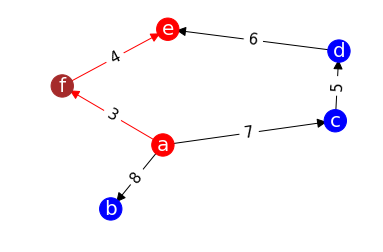

distances {'a': inf, 'c': inf, 'b': 0, 'e': inf, 'd': inf, 'f': inf}
previous_vertices {'a': None, 'c': None, 'b': None, 'e': None, 'd': None, 'f': None}
shortest path:  []


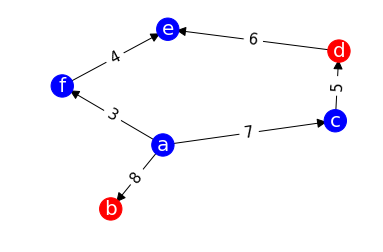

When negative weight presents
distances {'a': 0, 'c': -7, 'b': 8, 'e': 4, 'd': -2, 'f': 3}
previous_vertices {'a': None, 'c': 'a', 'b': 'a', 'e': 'd', 'd': 'c', 'f': 'a'}
shortest path:  [('a', 'c'), ('c', 'd'), ('d', 'e')]


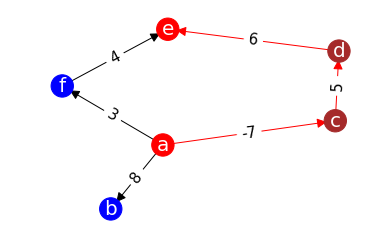

distances {'a': 0, 'c': 7, 'b': 8, 'e': 0, 'd': -6, 'g': 11, 'f': 3}
previous_vertices {'a': None, 'c': 'a', 'b': 'a', 'e': 'd', 'd': 'a', 'g': 'c', 'f': 'a'}
shortest path:  [('a', 'c')]


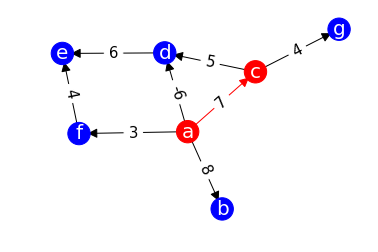

distances {'a': 0, 'c': 7, 'b': 8, 'e': 0, 'd': -6, 'g': 11, 'f': 3}
previous_vertices {'a': None, 'c': 'a', 'b': 'a', 'e': 'd', 'd': 'a', 'g': 'c', 'f': 'a'}
shortest path:  [('a', 'c'), ('c', 'g')]


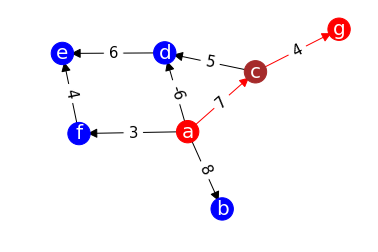

In [218]:
graph = Graph()
graph.add_edge("a", "c", 7)
graph.add_edge("a", "b", 8)
graph.add_edge("c", "d", 5)
graph.add_edge("d", "e", 6)
graph.add_edge("a", "f", 3)
graph.add_edge("f", "e", 4)

print "There is no negative weight"
path = graph.dijkstra("a", "e")
print "shortest path: ", list(zip(path,path[1:]))
graph.draw("a", "e", path)


path = graph.dijkstra("b", "d")
print "shortest path: ", list(zip(path,path[1:]))
graph.draw("b", "d", path)

print "When negative weight presents"
graph = Graph()
graph.add_edge("a", "c", -7)
graph.add_edge("a", "b", 8)
graph.add_edge("c", "d", 5)
graph.add_edge("d", "e", 6)
graph.add_edge("a", "f", 3)
graph.add_edge("f", "e", 4)

path = graph.dijkstra("a", "e")
print "shortest path: ", list(zip(path,path[1:]))
graph.draw("a", "e", path)

graph = Graph()
graph.add_edge("a", "c", 7)
graph.add_edge("a", "b", 8)
graph.add_edge("c", "d", 5)
graph.add_edge("d", "e", 6)
graph.add_edge("a", "d", -6)
graph.add_edge("a", "f", 3)
graph.add_edge("f", "e", 4)
graph.add_edge("c", "g", 4)

path = graph.dijkstra("a", "c")
print "shortest path: ", list(zip(path,path[1:]))
graph.draw("a", "c", path)
path = graph.dijkstra("a", "g")
print "shortest path: ", list(zip(path,path[1:]))
graph.draw("a", "g", path)


## Bellman_ford

distances {'a': 0, 'c': 4, 'b': 1, 'e': 3, 'd': 3}
previous_vertices {'a': None, 'c': 'a', 'b': 'a', 'e': 'b', 'd': 'b'}
Graph contains negative weight cycle at d e
shortest path:  []


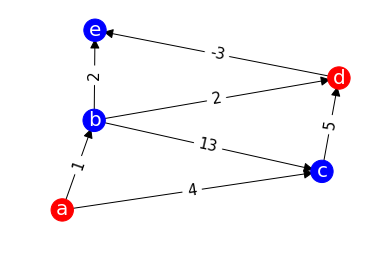

distances {'a': 0, 'c': 4, 'b': 1, 'e': -1, 'd': 3}
previous_vertices {'a': None, 'c': 'a', 'b': 'a', 'e': 'b', 'd': 'b'}
shortest path:  [('a', 'b'), ('b', 'd')]


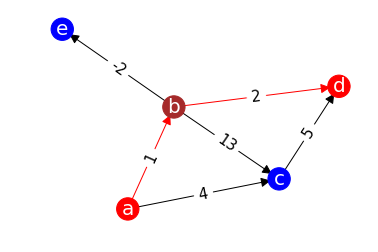

In [219]:
graph = Graph()
graph.add_edge("a", "c", 4)
graph.add_edge("a", "b", 1)
graph.add_edge("b", "c", 13)
graph.add_edge("b", "d", 2)
graph.add_edge("c", "d", 5)
graph.add_edge("d", "e", -3)
graph.add_edge("b", "e", 2)


path = graph.bellman_ford("a", "d")
print "shortest path: ", list(zip(path,path[1:]))
graph.draw("a", "d",path)

graph = Graph()
graph.add_edge("a", "c", 4)
graph.add_edge("a", "b", 1)
graph.add_edge("b", "c", 13)
graph.add_edge("b", "d", 2)
graph.add_edge("c", "d", 5)
graph.add_edge("b", "e", -2)


path = graph.bellman_ford("a", "d")
print "shortest path: ", list(zip(path,path[1:]))
graph.draw("a", "d",path)

## Floyd-Warshall

     a     b    c    d    e
a  inf   inf  inf  inf  inf
b  1.0   inf  inf  inf  inf
c  4.0  13.0  inf  inf  inf
d  3.0   2.0  5.0  inf  inf
e  3.0   2.0  8.0  3.0  inf
      a     b     c     d     e
a  None  None  None  None  None
b     b  None  None  None  None
c     c     c  None  None  None
d     b     d     d  None  None
e     b     e     d     e  None
shortest path:  [('a', 'b'), ('b', 'd')]


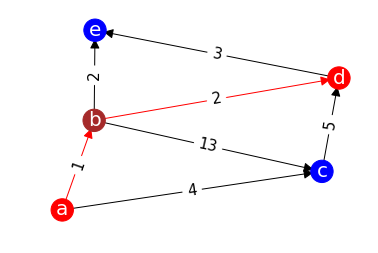

     a     b    c    d    e
a  inf   inf  inf  inf  inf
b  1.0   inf  inf  inf  inf
c  1.0  13.0  inf  inf  inf
d -4.0   2.0 -5.0  inf  inf
e -1.0   2.0 -2.0  3.0  inf
      a     b     c     d     e
a  None  None  None  None  None
b     b  None  None  None  None
c     c     c  None  None  None
d     c     d     d  None  None
e     c     e     d     e  None
shortest path:  [('a', 'c'), ('c', 'd')]


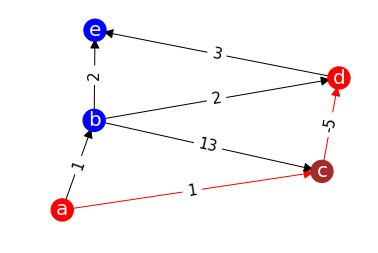

In [220]:
graph = Graph()
graph.add_edge("a", "c", 4)
graph.add_edge("a", "b", 1)
graph.add_edge("b", "c", 13)
graph.add_edge("b", "d", 2)
graph.add_edge("c", "d", 5)
graph.add_edge("d", "e", 3)
graph.add_edge("b", "e", 2)


path = graph.floyd_warshall("a", "d")
print "shortest path: ", list(zip(path,path[1:]))
graph.draw("a", "d",path)

graph = Graph()
graph.add_edge("a", "c", 1)
graph.add_edge("a", "b", 1)
graph.add_edge("b", "c", 13)
graph.add_edge("b", "d", 2)
graph.add_edge("c", "d", -5)
graph.add_edge("d", "e", 3)
graph.add_edge("b", "e", 2)


path = graph.floyd_warshall("a", "d")
print "shortest path: ", list(zip(path,path[1:]))
graph.draw("a", "d",path)

## Efficiency

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
from random import randrange, uniform
import time


def makeGraph(numberOfVertex):
    graph = Graph()
    for i in range(numberOfVertex):
        for j in range(numberOfVertex):
            graph.add_edge(i, j, randrange(0,numberOfVertex))
    return graph

In [221]:
efficiency_data = {'N': [],
                   'Time':[],
                   'Method': []
                    }
numberOfVerties = 50
for i in range(numberOfVerties):
    efficiency_data["N"].append(i)
    g = makeGraph(i)
    start_time = time.time()
    if(i>1):
        g.dijkstra(0, (i-1))
    running_time =  time.time() - start_time
    efficiency_data["Time"].append(running_time)
    efficiency_data["Method"].append("Dijkstra")


for i in range(numberOfVerties):
    efficiency_data["N"].append(i)
    g = makeGraph(i)
    start_time = time.time()
    if(i>1):
        g.bellman_ford(0, (i-1))
    running_time =  time.time() - start_time
    efficiency_data["Time"].append(running_time)
    efficiency_data["Method"].append("Bellman")

for i in range(numberOfVerties):
    efficiency_data["N"].append(i)
    g = makeGraph(i)
    start_time = time.time()
    if(i>1):
        g.floyd_warshall(0, (i-1))
    running_time =  time.time() - start_time
    efficiency_data["Time"].append(running_time)
    efficiency_data["Method"].append("Floyd")
    
    

distances {0: 0, 1: 0}
previous_vertices {0: None, 1: 0}
distances {0: 0, 1: 1, 2: 2}
previous_vertices {0: None, 1: 0, 2: 0}
distances {0: 0, 1: 0, 2: 3, 3: 0}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0}
distances {0: 0, 1: 0, 2: 3, 3: 0, 4: 0}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 3}
distances {0: 0, 1: 3, 2: 5, 3: 0, 4: 1, 5: 1}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 4}
distances {0: 0, 1: 3, 2: 1, 3: 3, 4: 4, 5: 3, 6: 3}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 2, 5: 3, 6: 3}
distances {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1}
previous_vertices {0: None, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 4, 7: 2}
distances {0: 0, 1: 1, 2: 1, 3: 1, 4: 6, 5: 1, 6: 3, 7: 2, 8: 3}
previous_vertices {0: None, 1: 0, 2: 1, 3: 1, 4: 0, 5: 3, 6: 1, 7: 3, 8: 0}
distances {0: 0, 1: 3, 2: 0, 3: 1, 4: 2, 5: 3, 6: 3, 7: 1, 8: 1, 9: 5}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 2, 6: 3, 7: 0, 8: 7, 9: 2}
distances {0: 0, 1: 1, 2: 0, 3: 5, 4: 6, 5: 1, 6: 1, 7:

distances {0: 0, 1: 27, 2: 5, 3: 6, 4: 23, 5: 11, 6: 7, 7: 15, 8: 4, 9: 10, 10: 0, 11: 5, 12: 7, 13: 6, 14: 1, 15: 2, 16: 3, 17: 5, 18: 5, 19: 5, 20: 3, 21: 4, 22: 0, 23: 4, 24: 5, 25: 2, 26: 0, 27: 1, 28: 3, 29: 7, 30: 1, 31: 0, 32: 1, 33: 4}
previous_vertices {0: None, 1: 0, 2: 0, 3: 2, 4: 0, 5: 0, 6: 0, 7: 2, 8: 0, 9: 3, 10: 0, 11: 8, 12: 11, 13: 0, 14: 0, 15: 14, 16: 0, 17: 2, 18: 15, 19: 10, 20: 0, 21: 14, 22: 10, 23: 20, 24: 15, 25: 0, 26: 0, 27: 0, 28: 10, 29: 0, 30: 10, 31: 10, 32: 14, 33: 32}
distances {0: 0, 1: 21, 2: 26, 3: 20, 4: 22, 5: 15, 6: 21, 7: 28, 8: 12, 9: 4, 10: 16, 11: 12, 12: 8, 13: 8, 14: 4, 15: 5, 16: 5, 17: 6, 18: 8, 19: 0, 20: 12, 21: 12, 22: 7, 23: 2, 24: 6, 25: 4, 26: 6, 27: 4, 28: 11, 29: 6, 30: 1, 31: 4, 32: 2, 33: 8, 34: 5}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 5, 7: 2, 8: 0, 9: 0, 10: 5, 11: 0, 12: 9, 13: 9, 14: 0, 15: 14, 16: 9, 17: 0, 18: 14, 19: 0, 20: 14, 21: 18, 22: 14, 23: 19, 24: 17, 25: 9, 26: 16, 27: 14, 28: 14, 29: 9, 30

distances {0: 0, 1: 14, 2: 10, 3: 3, 4: 15, 5: 12, 6: 9, 7: 13, 8: 7, 9: 8, 10: 19, 11: 10, 12: 15, 13: 12, 14: 16, 15: 14, 16: 4, 17: 10, 18: 5, 19: 13, 20: 11, 21: 8, 22: 7, 23: 10, 24: 14, 25: 7, 26: 1, 27: 6, 28: 11, 29: 12, 30: 11, 31: 9, 32: 6, 33: 8, 34: 1, 35: 1, 36: 2, 37: 8, 38: 12, 39: 4, 40: 8, 41: 10, 42: 5, 43: 5, 44: 5, 45: 7, 46: 8, 47: 3}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 3, 6: 0, 7: 3, 8: 0, 9: 0, 10: 8, 11: 0, 12: 0, 13: 3, 14: 6, 15: 2, 16: 0, 17: 3, 18: 16, 19: 17, 20: 0, 21: 18, 22: 8, 23: 22, 24: 2, 25: 3, 26: 0, 27: 3, 28: 2, 29: 26, 30: 23, 31: 3, 32: 26, 33: 26, 34: 0, 35: 0, 36: 26, 37: 3, 38: 20, 39: 26, 40: 22, 41: 25, 42: 0, 43: 26, 44: 16, 45: 34, 46: 37, 47: 3}
distances {0: 0, 1: 2, 2: 5, 3: 11, 4: 15, 5: 25, 6: 5, 7: 6, 8: 9, 9: 7, 10: 18, 11: 5, 12: 6, 13: 7, 14: 14, 15: 7, 16: 11, 17: 7, 18: 8, 19: 0, 20: 2, 21: 5, 22: 7, 23: 7, 24: 4, 25: 8, 26: 2, 27: 6, 28: 6, 29: 9, 30: 2, 31: 7, 32: 2, 33: 8, 34: 2, 35: 3, 36: 2, 37: 7, 38: 

distances {0: 0, 1: 21, 2: 16, 3: 2, 4: 5, 5: 18, 6: 0, 7: 0, 8: 14, 9: 0, 10: 8, 11: 7, 12: 8, 13: 2, 14: 1, 15: 0, 16: 2, 17: 4, 18: 0, 19: 0, 20: 1, 21: 1, 22: 0, 23: 2, 24: 0, 25: 2, 26: 2, 27: 6, 28: 4, 29: 1, 30: 1, 31: 4}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 6, 9: 7, 10: 3, 11: 7, 12: 11, 13: 0, 14: 6, 15: 9, 16: 14, 17: 16, 18: 9, 19: 18, 20: 9, 21: 7, 22: 15, 23: 6, 24: 22, 25: 6, 26: 7, 27: 7, 28: 22, 29: 6, 30: 19, 31: 29}
distances {0: 0, 1: 28, 2: 5, 3: 2, 4: 18, 5: 24, 6: 13, 7: 5, 8: 5, 9: 6, 10: 1, 11: 1, 12: 4, 13: 9, 14: 5, 15: 3, 16: 6, 17: 6, 18: 4, 19: 4, 20: 2, 21: 0, 22: 3, 23: 2, 24: 2, 25: 6, 26: 2, 27: 0, 28: 3, 29: 6, 30: 2, 31: 3, 32: 4}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 4, 6: 2, 7: 2, 8: 0, 9: 2, 10: 0, 11: 0, 12: 11, 13: 0, 14: 2, 15: 0, 16: 8, 17: 9, 18: 3, 19: 3, 20: 11, 21: 0, 22: 0, 23: 10, 24: 11, 25: 10, 26: 0, 27: 21, 28: 27, 29: 17, 30: 10, 31: 20, 32: 11}
distances {0: 0, 1: 19, 2: 25, 3: 22

distances {0: 0, 1: 44, 2: 15, 3: 7, 4: 6, 5: 22, 6: 12, 7: 13, 8: 16, 9: 17, 10: 19, 11: 15, 12: 12, 13: 17, 14: 18, 15: 11, 16: 14, 17: 14, 18: 14, 19: 14, 20: 7, 21: 11, 22: 7, 23: 14, 24: 11, 25: 16, 26: 15, 27: 13, 28: 17, 29: 13, 30: 12, 31: 9, 32: 2, 33: 13, 34: 13, 35: 0, 36: 1, 37: 14, 38: 2, 39: 9, 40: 5, 41: 12, 42: 5, 43: 9, 44: 4, 45: 5, 46: 8}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 2, 6: 0, 7: 3, 8: 2, 9: 3, 10: 7, 11: 0, 12: 4, 13: 6, 14: 4, 15: 3, 16: 12, 17: 7, 18: 17, 19: 3, 20: 0, 21: 4, 22: 4, 23: 0, 24: 0, 25: 23, 26: 24, 27: 22, 28: 3, 29: 6, 30: 21, 31: 22, 32: 0, 33: 0, 34: 6, 35: 0, 36: 0, 37: 4, 38: 36, 39: 35, 40: 38, 41: 38, 42: 36, 43: 32, 44: 0, 45: 35, 46: 35}
distances {0: 0, 1: 1, 2: 14, 3: 24, 4: 8, 5: 13, 6: 0, 7: 24, 8: 7, 9: 10, 10: 8, 11: 14, 12: 12, 13: 8, 14: 0, 15: 20, 16: 3, 17: 1, 18: 5, 19: 3, 20: 5, 21: 7, 22: 0, 23: 2, 24: 3, 25: 3, 26: 6, 27: 3, 28: 7, 29: 1, 30: 6, 31: 6, 32: 8, 33: 4, 34: 5, 35: 1, 36: 5, 37: 0, 38: 1, 39

    0     1    2     3    4     5     6     7     8     9     10   11   12  \
0   12   inf  inf   inf  inf   inf   inf   inf   inf   inf   inf  inf  inf   
1   11  10.0  inf   inf  inf   inf   inf   inf   inf   inf   inf  inf  inf   
2   13  11.0  9.0   inf  inf   inf   inf   inf   inf   inf   inf  inf  inf   
3    0   6.0  3.0  10.0  inf   inf   inf   inf   inf   inf   inf  inf  inf   
4    1   7.0  4.0   1.0  6.0   inf   inf   inf   inf   inf   inf  inf  inf   
5    1   7.0  0.0   1.0  7.0   2.0   inf   inf   inf   inf   inf  inf  inf   
6    5   2.0  8.0   5.0  4.0  10.0   1.0   inf   inf   inf   inf  inf  inf   
7    0   7.0  2.0   1.0  2.0   3.0   9.0   4.0   inf   inf   inf  inf  inf   
8    1   3.0  3.0   1.0  3.0   4.0   9.0   1.0   6.0   inf   inf  inf  inf   
9    1   5.0  4.0   1.0  0.0  12.0   7.0  11.0  12.0   5.0   inf  inf  inf   
10   1   5.0  4.0   1.0  4.0   5.0   8.0   3.0   2.0  10.0   7.0  inf  inf   
11   1   7.0  2.0   2.0  4.0   2.0   5.0   2.0  11.0  11.0  11.0

    0    1     2     3     4     5     6     7     8     9     10    11    12  \
0    8  inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   
1    9  7.0   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   
2    7  0.0   1.0   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   
3   15  9.0  14.0   2.0   inf   inf   inf   inf   inf   inf   inf   inf   inf   
4   14  5.0  14.0  11.0  13.0   inf   inf   inf   inf   inf   inf   inf   inf   
5   10  1.0   8.0   5.0  14.0  17.0   inf   inf   inf   inf   inf   inf   inf   
6    6  5.0  12.0   9.0   8.0   4.0   4.0   inf   inf   inf   inf   inf   inf   
7    7  8.0  13.0   2.0  13.0   7.0  10.0   9.0   inf   inf   inf   inf   inf   
8    7  3.0  13.0   6.0   4.0   5.0   1.0  15.0  17.0   inf   inf   inf   inf   
9    6  2.0   4.0   4.0   4.0   7.0   3.0   2.0   2.0   6.0   inf   inf   inf   
10   7  7.0  11.0   2.0   2.0   7.0  10.0   0.0   9.0  15.0  14.0   inf   inf   
11  10  2.0   3.0   0.0   7.

    0     1     2     3     4     5     6     7     8     9     10    11  \
0   15   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   
1    3   9.0   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   
2    4   1.0  16.0   inf   inf   inf   inf   inf   inf   inf   inf   inf   
3   11   8.0   9.0  12.0   inf   inf   inf   inf   inf   inf   inf   inf   
4    9   6.0  12.0   3.0  10.0   inf   inf   inf   inf   inf   inf   inf   
5    8   5.0   4.0  15.0  18.0  13.0   inf   inf   inf   inf   inf   inf   
6    6   6.0   5.0   6.0   3.0   1.0  17.0   inf   inf   inf   inf   inf   
7    1   9.0   8.0   9.0   6.0  10.0   9.0  19.0   inf   inf   inf   inf   
8   12  13.0  14.0  15.0  12.0  10.0   9.0  11.0  17.0   inf   inf   inf   
9    0   8.0   9.0   9.0   6.0   5.0   4.0   3.0  18.0   1.0   inf   inf   
10   3   1.0  10.0   9.0   6.0  12.0  11.0   2.0  13.0  14.0   7.0   inf   
11   2   0.0  10.0   5.0   2.0   6.0   5.0   6.0   8.0   3.0  18.0  15.0   
12   1   1.0

    0     1     2     3    4     5     6     7     8     9   ...    12    13  \
0   11   inf   inf   inf  inf   inf   inf   inf   inf   inf  ...   inf   inf   
1    9   2.0   inf   inf  inf   inf   inf   inf   inf   inf  ...   inf   inf   
2    9   0.0  20.0   inf  inf   inf   inf   inf   inf   inf  ...   inf   inf   
3    6   4.0   4.0  18.0  inf   inf   inf   inf   inf   inf  ...   inf   inf   
4    6  12.0  12.0   8.0  3.0   inf   inf   inf   inf   inf  ...   inf   inf   
5    6   5.0   5.0   1.0  6.0  21.0   inf   inf   inf   inf  ...   inf   inf   
6    6   5.0   5.0   1.0  6.0   0.0  14.0   inf   inf   inf  ...   inf   inf   
7    2   8.0   8.0   4.0  8.0   3.0  20.0   0.0   inf   inf  ...   inf   inf   
8    6   6.0   7.0   5.0  0.0   4.0   4.0   6.0  11.0   inf  ...   inf   inf   
9    8   8.0   9.0   7.0  2.0   6.0   6.0   8.0   2.0   5.0  ...   inf   inf   
10   0   6.0   6.0   9.0  5.0   8.0  15.0  14.0  11.0  19.0  ...   inf   inf   
11   3   7.0   7.0  10.0  5.0   9.0   9.

    0     1     2     3     4     5     6     7     8     9   ...    14    15  \
0   16   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   19  22.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2    7  13.0  16.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   12   4.0   8.0  18.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4    3  18.0  18.0  14.0  13.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   10   9.0  14.0   9.0  16.0  13.0   inf   inf   inf   inf  ...   inf   inf   
6    2   1.0  10.0  16.0  23.0   7.0  11.0   inf   inf   inf  ...   inf   inf   
7   11  10.0  15.0   7.0  17.0   1.0  14.0  19.0   inf   inf  ...   inf   inf   
8    8   5.0   9.0   1.0  18.0   2.0   9.0  22.0  18.0   inf  ...   inf   inf   
9    1   2.0   5.0   4.0   3.0   5.0   1.0   6.0   3.0   4.0  ...   inf   inf   
10   9   5.0   9.0   1.0  17.0   5.0   7.0  10.0  15.0  23.0  ...   inf   inf   
11  10  10.0  19.0  12.0   7

    0     1     2     3     4     5     6     7     8     9   ...    16    17  \
0    8   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   23   4.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   14  24.0  24.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3    0  25.0  14.0   7.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4    7  22.0  19.0   7.0  23.0   inf   inf   inf   inf   inf  ...   inf   inf   
5    7   0.0   0.0   7.0   0.0   8.0   inf   inf   inf   inf  ...   inf   inf   
6    7   0.0   3.0  10.0   3.0   3.0  17.0   inf   inf   inf  ...   inf   inf   
7    6  10.0   0.0   9.0  10.0  10.0  14.0   1.0   inf   inf  ...   inf   inf   
8    4   8.0  15.0   4.0  14.0  15.0  19.0  23.0  14.0   inf  ...   inf   inf   
9   12  10.0   6.0  12.0   8.0  10.0  10.0   7.0  13.0   0.0  ...   inf   inf   
10   7  11.0   1.0  10.0  11.0  11.0  14.0   1.0  21.0  12.0  ...   inf   inf   
11   9   2.0   4.0   9.0   4

    0     1     2     3     4     5     6     7     8     9   ...    18    19  \
0    0   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   20   8.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2    3   6.0  13.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3    9  12.0   6.0  10.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   12  15.0   9.0  26.0   6.0   inf   inf   inf   inf   inf  ...   inf   inf   
5    1  19.0  13.0   7.0  18.0  21.0   inf   inf   inf   inf  ...   inf   inf   
6   10  13.0   7.0  24.0  17.0  17.0  23.0   inf   inf   inf  ...   inf   inf   
7   12   1.0   9.0  22.0  14.0  15.0   2.0  22.0   inf   inf  ...   inf   inf   
8    3   6.0   0.0  13.0   0.0   8.0   7.0   5.0  25.0   inf  ...   inf   inf   
9    3   5.0   0.0  13.0   0.0   8.0   2.0   5.0   0.0  10.0  ...   inf   inf   
10   8  10.0   5.0   8.0   1.0   9.0   2.0  10.0   5.0   5.0  ...   inf   inf   
11   0   6.0   0.0   0.0   1

    0     1     2     3     4     5     6     7     8     9   ...    20    21  \
0   17   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1    0   2.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2    2  25.0   0.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   10  10.0  16.0   7.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   10  17.0   8.0  13.0  22.0   inf   inf   inf   inf   inf  ...   inf   inf   
5    8   8.0  22.0  13.0  22.0  16.0   inf   inf   inf   inf  ...   inf   inf   
6    1  10.0   3.0   0.0  23.0   7.0   8.0   inf   inf   inf  ...   inf   inf   
7    9   9.0  11.0   8.0   3.0   3.0   8.0  18.0   inf   inf  ...   inf   inf   
8    0   0.0   7.0   0.0   3.0   8.0   4.0  28.0  12.0   inf  ...   inf   inf   
9    4  12.0  12.0  12.0  16.0  24.0  20.0  21.0  16.0  24.0  ...   inf   inf   
10   1   8.0   3.0   0.0   7.0   7.0   0.0  23.0   8.0  24.0  ...   inf   inf   
11   8  12.0  11.0   8.0   6

    0     1     2     3     4     5     6     7     8     9   ...    21    22  \
0   26   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1    6   3.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   11   5.0   8.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   25  19.0  14.0   3.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   12  15.0  10.0  10.0  26.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   13   9.0  14.0  14.0   4.0  19.0   inf   inf   inf   inf  ...   inf   inf   
6   18  13.0  16.0  16.0   6.0  12.0  21.0   inf   inf   inf  ...   inf   inf   
7   13  16.0  11.0  11.0   1.0   8.0  27.0  27.0   inf   inf  ...   inf   inf   
8   20  15.0  17.0   3.0   8.0  14.0   2.0  11.0  28.0   inf  ...   inf   inf   
9   14  21.0  19.0   9.0   9.0  16.0   8.0   8.0   6.0  16.0  ...   inf   inf   
10  12   6.0  18.0  10.0  10.0  16.0   9.0   9.0   7.0   1.0  ...   inf   inf   
11  10  15.0  12.0  12.0   2

    0     1     2     3     4     5     6     7     8     9   ...    22    23  \
0   28   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   14   2.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   15  29.0   0.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3    3   3.0   4.0   2.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   16   2.0  28.0  31.0   9.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   18   4.0   7.0  28.0  12.0  14.0   inf   inf   inf   inf  ...   inf   inf   
6   18   4.0  16.0  28.0  21.0   9.0   2.0   inf   inf   inf  ...   inf   inf   
7   21   7.0  21.0  28.0  19.0  24.0  20.0  16.0   inf   inf  ...   inf   inf   
8   22   8.0  14.0  23.0  10.0  13.0   4.0  22.0  25.0   inf  ...   inf   inf   
9   16   5.0  23.0  24.0   3.0  19.0  10.0  12.0  26.0  28.0  ...   inf   inf   
10   5   2.0   6.0   2.0  11.0  13.0   4.0   4.0   6.0  10.0  ...   inf   inf   
11  11   2.0  12.0   8.0  17

    0     1     2     3     4     5     6     7     8     9   ...    23    24  \
0   13   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1    7   9.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2    7   7.0  18.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   18  23.0  19.0  31.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   18  11.0  13.0  10.0  12.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   22  15.0  17.0   6.0   4.0  21.0   inf   inf   inf   inf  ...   inf   inf   
6   18  18.0  11.0  31.0  21.0  31.0  22.0   inf   inf   inf  ...   inf   inf   
7    6  13.0   6.0   9.0   7.0   3.0  18.0   1.0   inf   inf  ...   inf   inf   
8    8   8.0   1.0   0.0   0.0  11.0   1.0   8.0  18.0   inf  ...   inf   inf   
9   10  10.0   3.0  16.0  14.0  10.0  17.0   7.0  16.0  20.0  ...   inf   inf   
10  13  15.0   8.0  16.0  14.0  10.0   8.0   7.0  30.0  26.0  ...   inf   inf   
11  15   8.0  22.0  14.0  22

    0     1     2     3     4     5     6     7     8     9   ...    24    25  \
0    7   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   22   9.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   22  14.0  27.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   21  24.0  22.0  16.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   19   8.0  26.0  18.0   6.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   11  20.0  20.0  12.0  12.0  12.0   inf   inf   inf   inf  ...   inf   inf   
6   20  15.0  16.0   4.0  16.0   9.0  24.0   inf   inf   inf  ...   inf   inf   
7   14   1.0   4.0   2.0  19.0   7.0   3.0  17.0   inf   inf  ...   inf   inf   
8    3  17.0  18.0   6.0  12.0   0.0   2.0  32.0   1.0   inf  ...   inf   inf   
9    4   8.0   1.0   9.0   9.0  14.0  10.0   7.0  14.0  13.0  ...   inf   inf   
10  14   0.0   4.0   2.0   7.0   7.0   3.0   0.0  22.0  33.0  ...   inf   inf   
11   0   9.0   5.0  10.0  13

    0     1     2     3     4     5     6     7     8     9   ...    25    26  \
0   28   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1    6  25.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   14  12.0  27.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   16  27.0  23.0   6.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   22  23.0  23.0  25.0  29.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   23  17.0  20.0  30.0  19.0  11.0   inf   inf   inf   inf  ...   inf   inf   
6   13  23.0  24.0  30.0  33.0  14.0  29.0   inf   inf   inf  ...   inf   inf   
7    0  23.0  11.0  29.0   8.0  25.0  23.0  18.0   inf   inf  ...   inf   inf   
8   10   7.0  23.0   4.0  20.0  30.0  25.0  12.0   5.0   inf  ...   inf   inf   
9    1  15.0  24.0   6.0  21.0  15.0  30.0  13.0  33.0   2.0  ...   inf   inf   
10   1  16.0   5.0  18.0  30.0  11.0   1.0  25.0  17.0  12.0  ...   inf   inf   
11   3  14.0  14.0  10.0  11

    0     1     2     3     4     5     6     7     8     9   ...    26    27  \
0   30   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1    9  33.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   21  32.0   4.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   19  13.0   9.0  30.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4    9   1.0  14.0   5.0  27.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   18   9.0  33.0  34.0  30.0  22.0   inf   inf   inf   inf  ...   inf   inf   
6   15   6.0  27.0  26.0  29.0  27.0  30.0   inf   inf   inf  ...   inf   inf   
7    3   2.0   0.0   6.0   1.0   0.0  27.0  35.0   inf   inf  ...   inf   inf   
8   16   8.0   4.0  12.0   7.0  18.0   7.0  20.0  24.0   inf  ...   inf   inf   
9    8  25.0  21.0  27.0  24.0  23.0  25.0  23.0  22.0   2.0  ...   inf   inf   
10   0   9.0  10.0   5.0  12.0   0.0  13.0  11.0  16.0  10.0  ...   inf   inf   
11   7  14.0   5.0   4.0  13

    0     1     2     3     4     5     6     7     8     9   ...    27    28  \
0   28   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1    5  15.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   11  16.0  13.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3    6  17.0  29.0  29.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4    6  13.0  30.0  24.0  25.0   inf   inf   inf   inf   inf  ...   inf   inf   
5    9   4.0  21.0   5.0  29.0  17.0   inf   inf   inf   inf  ...   inf   inf   
6    9   4.0   1.0   5.0  29.0   0.0  24.0   inf   inf   inf  ...   inf   inf   
7   13   8.0   5.0   9.0  27.0   4.0   4.0  28.0   inf   inf  ...   inf   inf   
8    2   8.0   5.0   9.0  27.0   4.0   4.0   0.0  12.0   inf  ...   inf   inf   
9    8   8.0   5.0   9.0   2.0   4.0   4.0  17.0  17.0  15.0  ...   inf   inf   
10   6  17.0  17.0   0.0  31.0  16.0  29.0  25.0  36.0  29.0  ...   inf   inf   
11   2   8.0   5.0   4.0  27

    0     1     2     3     4     5     6     7     8     9   ...    28    29  \
0   10   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   26  34.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   15  31.0  14.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3    9   9.0  30.0   1.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   23   5.0  33.0  23.0   4.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   27  29.0  26.0  33.0  31.0  37.0   inf   inf   inf   inf  ...   inf   inf   
6   11   9.0  20.0  11.0   4.0   8.0   5.0   inf   inf   inf  ...   inf   inf   
7   19  20.0  19.0  12.0  15.0   3.0  22.0  20.0   inf   inf  ...   inf   inf   
8    6   8.0  30.0   4.0   3.0  24.0  16.0  28.0  23.0   inf  ...   inf   inf   
9   13  10.0  22.0   4.0   5.0  12.0  25.0  23.0  30.0   6.0  ...   inf   inf   
10   1   6.0  13.0   7.0  10.0  14.0  14.0  11.0  16.0  34.0  ...   inf   inf   
11   6   8.0   4.0   4.0   3

    0     1     2     3     4     5     6     7     8     9   ...    29    30  \
0   31   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   16   8.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   16  22.0  20.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   22   6.0  37.0  33.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4    4  22.0  27.0  16.0  17.0   inf   inf   inf   inf   inf  ...   inf   inf   
5    9  12.0  31.0  21.0   5.0  16.0   inf   inf   inf   inf  ...   inf   inf   
6    3  11.0  37.0  12.0  11.0   6.0  36.0   inf   inf   inf  ...   inf   inf   
7   15  23.0  17.0  24.0  23.0  18.0  12.0  20.0   inf   inf  ...   inf   inf   
8   18  17.0  20.0  27.0  21.0  21.0  15.0   3.0  26.0   inf  ...   inf   inf   
9    9  17.0   0.0  16.0  12.0   7.0   6.0  20.0  21.0  24.0  ...   inf   inf   
10  22   6.0  16.0   0.0  24.0  23.0  22.0  18.0  15.0  16.0  ...   inf   inf   
11   5  21.0   5.0  15.0   1

    0     1     2     3     4     5     6     7     8     9   ...    30    31  \
0   28   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   13   8.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   20  30.0  27.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   33  20.0  25.0   3.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   30  27.0  21.0  28.0   6.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   29  20.0  15.0  37.0  26.0  15.0   inf   inf   inf   inf  ...   inf   inf   
6   24  30.0  23.0  15.0   3.0  31.0  16.0   inf   inf   inf  ...   inf   inf   
7   22  16.0   2.0  22.0  22.0  23.0  19.0  28.0   inf   inf  ...   inf   inf   
8   16   3.0  25.0  17.0   5.0  16.0   2.0  31.0  15.0   inf  ...   inf   inf   
9   12  12.0  28.0  26.0  14.0  15.0  11.0  26.0   9.0  17.0  ...   inf   inf   
10  19  27.0   0.0  12.0  21.0  28.0  18.0  34.0  24.0  15.0  ...   inf   inf   
11  20  10.0   1.0  13.0  10

    0     1     2     3     4     5     6     7     8     9   ...    31    32  \
0    4   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   30  28.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   21   7.0  31.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3    5  10.0  30.0   3.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4    6   9.0  38.0  34.0   3.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   14   9.0  13.0  28.0   8.0  30.0   inf   inf   inf   inf  ...   inf   inf   
6   16  11.0  15.0  20.0  10.0   2.0  38.0   inf   inf   inf  ...   inf   inf   
7   21   7.0   0.0  23.0  20.0  14.0  12.0  35.0   inf   inf  ...   inf   inf   
8   12   9.0   8.0  23.0   8.0   0.0  26.0  38.0   2.0   inf  ...   inf   inf   
9   12  15.0   8.0  11.0   6.0  15.0  20.0   8.0  33.0   2.0  ...   inf   inf   
10   5  10.0   9.0   0.0   9.0   1.0  25.0  15.0   1.0  19.0  ...   inf   inf   
11  16  14.0   7.0  11.0  21

    0     1     2     3     4     5     6     7     8     9   ...    32    33  \
0   33   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1    1  14.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   18  40.0  41.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   17  31.0   7.0  25.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4    5  35.0  33.0  30.0   3.0   inf   inf   inf   inf   inf  ...   inf   inf   
5    5  35.0  16.0  29.0   0.0  19.0   inf   inf   inf   inf  ...   inf   inf   
6   22  39.0  12.0  19.0  34.0  34.0   3.0   inf   inf   inf  ...   inf   inf   
7    1  11.0  20.0  19.0   4.0  24.0  21.0  22.0   inf   inf  ...   inf   inf   
8    1  11.0  10.0  19.0   4.0  24.0  20.0   0.0  35.0   inf  ...   inf   inf   
9   11  16.0  16.0   9.0   6.0  13.0  33.0  29.0  31.0  20.0  ...   inf   inf   
10   5  22.0   1.0  30.0   0.0  21.0  39.0  29.0  29.0  37.0  ...   inf   inf   
11  20  23.0   2.0  33.0  27

    0     1     2     3     4     5     6     7     8     9   ...    33    34  \
0   35   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1    2  33.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2    4   2.0  28.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3    8   6.0   4.0  33.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   20  18.0  16.0  31.0  42.0   inf   inf   inf   inf   inf  ...   inf   inf   
5    8   8.0  30.0  32.0  14.0   5.0   inf   inf   inf   inf  ...   inf   inf   
6    1  34.0  35.0  42.0  19.0  41.0  14.0   inf   inf   inf  ...   inf   inf   
7   15  13.0  11.0  42.0  18.0  31.0  33.0  27.0   inf   inf  ...   inf   inf   
8   26  24.0  25.0  25.0  33.0  36.0  40.0  36.0   6.0   inf  ...   inf   inf   
9   10   8.0   6.0   2.0  32.0  26.0  42.0  38.0  32.0  18.0  ...   inf   inf   
10   7  14.0  12.0  12.0  12.0  36.0  12.0  32.0   4.0  10.0  ...   inf   inf   
11   8   7.0  13.0   9.0   6

    0     1     2     3     4     5     6     7     8     9   ...    34    35  \
0   33   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   32  24.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   31   3.0   1.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   32   4.0   1.0   2.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   12  25.0  22.0  41.0  41.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   12  15.0  22.0  21.0   0.0   4.0   inf   inf   inf   inf  ...   inf   inf   
6   16   4.0   1.0  24.0   4.0  22.0   7.0   inf   inf   inf  ...   inf   inf   
7   11   5.0   2.0  25.0   5.0  23.0   1.0  26.0   inf   inf  ...   inf   inf   
8   16   7.0  16.0  15.0   4.0   8.0  35.0  34.0  36.0   inf  ...   inf   inf   
9   13  11.0   8.0  16.0   1.0   1.0  22.0  21.0  27.0  21.0  ...   inf   inf   
10  25  17.0  16.0  27.0  16.0  20.0  15.0  14.0  12.0  43.0  ...   inf   inf   
11  12   3.0   2.0  18.0   4

    0     1     2     3     4     5     6     7     8     9   ...    35    36  \
0   20   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1    5  24.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2    5   0.0  12.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3    5   0.0  34.0  15.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4    3  14.0  14.0  30.0   2.0   inf   inf   inf   inf   inf  ...   inf   inf   
5    5   0.0   0.0  10.0  33.0  16.0   inf   inf   inf   inf  ...   inf   inf   
6   16  22.0  27.0  36.0  13.0  35.0  28.0   inf   inf   inf  ...   inf   inf   
7   18  13.0  13.0  17.0  28.0  13.0  15.0  11.0   inf   inf  ...   inf   inf   
8   15  11.0  29.0  26.0  26.0  30.0  13.0  43.0  10.0   inf  ...   inf   inf   
9    8   3.0   3.0  13.0   6.0   3.0  24.0   9.0  30.0  32.0  ...   inf   inf   
10  10   7.0   7.0  17.0   7.0   7.0   6.0  22.0  43.0  13.0  ...   inf   inf   
11   5   0.0   0.0  20.0  10

    0     1     2     3     4     5     6     7     8     9   ...    36    37  \
0   23   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   17  15.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   13  17.0   8.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   23  28.0  11.0  19.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   10  31.0  18.0   7.0  31.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   27  31.0  14.0  16.0  26.0  15.0   inf   inf   inf   inf  ...   inf   inf   
6   22  18.0   9.0  16.0  33.0  22.0  43.0   inf   inf   inf  ...   inf   inf   
7   20  31.0  14.0  17.0  10.0  18.0  43.0  44.0   inf   inf  ...   inf   inf   
8   23  34.0  17.0  20.0  13.0  21.0  41.0   3.0   3.0   inf  ...   inf   inf   
9   25   9.0  21.0  24.0  17.0  25.0  21.0   7.0  42.0   8.0  ...   inf   inf   
10   4   1.0  11.0   0.0  17.0  19.0  34.0   7.0  13.0  37.0  ...   inf   inf   
11  22  15.0  16.0  19.0  12

    0     1     2     3     4     5     6     7     8     9   ...    37    38  \
0   17   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   43  39.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   37  16.0  24.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   19  37.0  36.0  37.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   25  14.0  17.0   6.0  42.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   34  10.0  29.0  15.0  12.0  37.0   inf   inf   inf   inf  ...   inf   inf   
6    6  25.0  43.0   8.0  43.0  43.0  41.0   inf   inf   inf  ...   inf   inf   
7   13  21.0   5.0  17.0  25.0  14.0   9.0  27.0   inf   inf  ...   inf   inf   
8    7  10.0  10.0  15.0  23.0  46.0   7.0  41.0  34.0   inf  ...   inf   inf   
9    7  22.0  11.0   9.0  31.0  20.0   1.0   6.0  12.0  41.0  ...   inf   inf   
10   9  23.0  25.0  15.0   9.0  19.0  25.0  20.0  18.0  36.0  ...   inf   inf   
11  10   0.0  17.0   2.0  31

    0     1     2     3     4     5     6     7     8     9   ...    38    39  \
0   38   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1   23  44.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   40  41.0  24.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   35  12.0  20.0   4.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   38  33.0  29.0  21.0   7.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   30  12.0  42.0  22.0  33.0  32.0   inf   inf   inf   inf  ...   inf   inf   
6   37  19.0  32.0  27.0   6.0   7.0   6.0   inf   inf   inf  ...   inf   inf   
7   35  12.0  13.0  27.0   6.0   7.0   0.0   0.0   inf   inf  ...   inf   inf   
8   15  29.0  31.0  28.0  19.0  33.0  38.0  38.0  38.0   inf  ...   inf   inf   
9   36  18.0  22.0  28.0   7.0   6.0   1.0   9.0  27.0   6.0  ...   inf   inf   
10  18  22.0  22.0  24.0   3.0  10.0   3.0  38.0   3.0  47.0  ...   inf   inf   
11  21  28.0  31.0  23.0   2

    0     1     2     3     4     5     6     7     8     9   ...    39    40  \
0   44   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
1    1   6.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
2   18  41.0  18.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   inf   
3   17  16.0   7.0  25.0   inf   inf   inf   inf   inf   inf  ...   inf   inf   
4   11  10.0  20.0  13.0  48.0   inf   inf   inf   inf   inf  ...   inf   inf   
5   12  11.0  19.0  14.0   1.0  46.0   inf   inf   inf   inf  ...   inf   inf   
6   13  12.0  22.0  15.0   2.0  47.0   9.0   inf   inf   inf  ...   inf   inf   
7    3   2.0  22.0  15.0   2.0  18.0   0.0  42.0   inf   inf  ...   inf   inf   
8    5   4.0   7.0   0.0   4.0  20.0   2.0   2.0   5.0   inf  ...   inf   inf   
9   11  10.0  12.0  11.0   0.0  31.0  13.0  13.0  11.0  48.0  ...   inf   inf   
10   7   6.0  21.0  15.0   6.0  22.0   4.0   4.0  15.0  25.0  ...   inf   inf   
11   7   6.0  23.0  16.0   9

Text(0.5,1,'Comparing peformance of sp method')

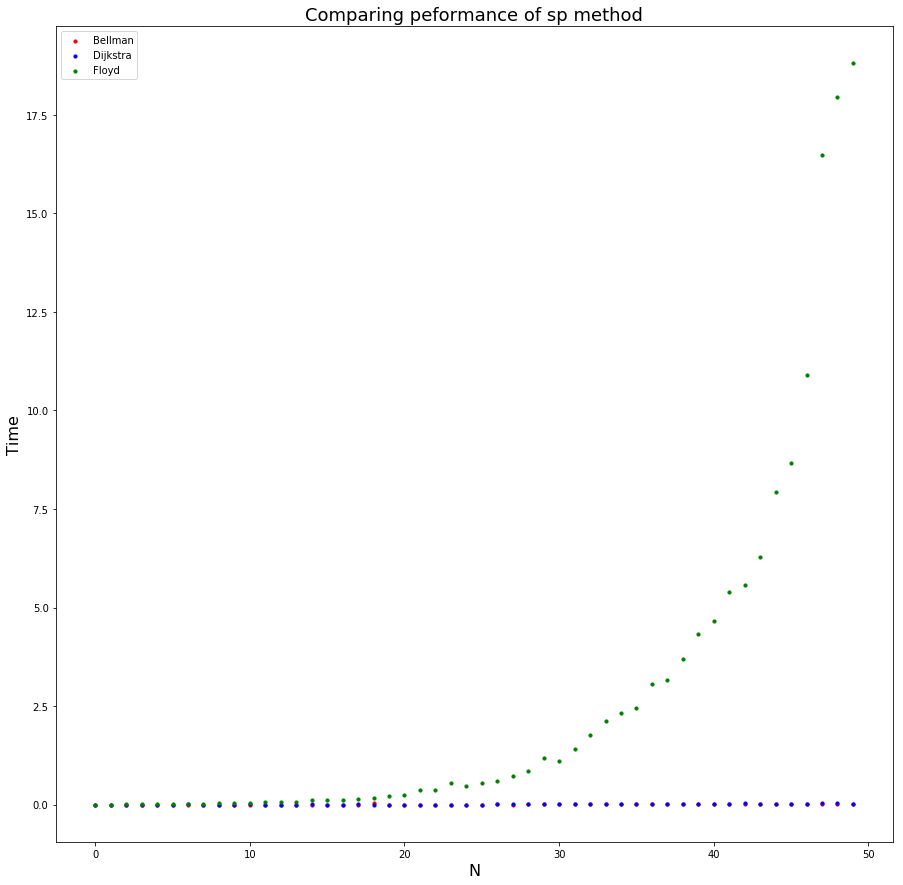

In [222]:
import pandas as pd
com_df = pd.DataFrame (efficiency_data)
fig, ax = plt.subplots(figsize=(15,15))

cols = {"Dijkstra": 'blue', "Bellman": 'red', "Floyd": 'green' }
for  mt, grouped in com_df.groupby('Method'):
    ax.scatter(grouped['N'], grouped['Time'], label=mt, c=cols[mt], s =10)
    
plt.xlabel('N', fontsize=16)
plt.ylabel('Time', fontsize=16)
plt.legend(loc=2)
plt.title("Comparing peformance of sp method",fontsize=18)

### Compare only dijkstra  and bellman_ford

In [223]:
efficiency_data = {'N': [],
                   'Time':[],
                   'Method': []
                    }
numberOfVerties = 100
for i in range(numberOfVerties):
    efficiency_data["N"].append(i)
    g = makeGraph(i)
    start_time = time.time()
    if(i>1):
        g.dijkstra(0, (i-1))
    running_time =  time.time() - start_time
    efficiency_data["Time"].append(running_time)
    efficiency_data["Method"].append("Dijkstra")


for i in range(numberOfVerties):
    efficiency_data["N"].append(i)
    g = makeGraph(i)
    start_time = time.time()
    if(i>1):
        g.bellman_ford(0, (i-1))
    running_time =  time.time() - start_time
    efficiency_data["Time"].append(running_time)
    efficiency_data["Method"].append("Bellman")


distances {0: 0, 1: 1}
previous_vertices {0: None, 1: 0}
distances {0: 0, 1: 2, 2: 1}
previous_vertices {0: None, 1: 0, 2: 0}
distances {0: 0, 1: 2, 2: 2, 3: 2}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0}
distances {0: 0, 1: 1, 2: 2, 3: 2, 4: 0}
previous_vertices {0: None, 1: 0, 2: 1, 3: 1, 4: 0}
distances {0: 0, 1: 2, 2: 2, 3: 2, 4: 0, 5: 0}
previous_vertices {0: None, 1: 0, 2: 1, 3: 2, 4: 0, 5: 0}
distances {0: 0, 1: 1, 2: 3, 3: 4, 4: 1, 5: 2, 6: 1}
previous_vertices {0: None, 1: 0, 2: 0, 3: 2, 4: 0, 5: 0, 6: 0}
distances {0: 0, 1: 6, 2: 6, 3: 3, 4: 3, 5: 4, 6: 3, 7: 1}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
distances {0: 0, 1: 8, 2: 0, 3: 2, 4: 0, 5: 3, 6: 0, 7: 1, 8: 0}
previous_vertices {0: None, 1: 0, 2: 0, 3: 2, 4: 2, 5: 4, 6: 0, 7: 2, 8: 6}
distances {0: 0, 1: 5, 2: 6, 3: 2, 4: 0, 5: 2, 6: 3, 7: 2, 8: 1, 9: 1}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 3, 7: 3, 8: 0, 9: 0}
distances {0: 0, 1: 7, 2: 6, 3: 4, 4: 7, 5: 2, 6: 2, 7:

distances {0: 0, 1: 13, 2: 17, 3: 25, 4: 21, 5: 18, 6: 9, 7: 21, 8: 5, 9: 19, 10: 19, 11: 11, 12: 14, 13: 8, 14: 9, 15: 6, 16: 10, 17: 10, 18: 2, 19: 15, 20: 8, 21: 2, 22: 10, 23: 11, 24: 7, 25: 4, 26: 1, 27: 2, 28: 4, 29: 1, 30: 9, 31: 5, 32: 5, 33: 4}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 8, 10: 1, 11: 0, 12: 8, 13: 0, 14: 13, 15: 0, 16: 6, 17: 15, 18: 0, 19: 11, 20: 13, 21: 18, 22: 8, 23: 14, 24: 8, 25: 18, 26: 0, 27: 26, 28: 0, 29: 26, 30: 21, 31: 0, 32: 8, 33: 28}
distances {0: 0, 1: 20, 2: 32, 3: 29, 4: 25, 5: 20, 6: 25, 7: 3, 8: 21, 9: 5, 10: 20, 11: 13, 12: 9, 13: 6, 14: 21, 15: 16, 16: 6, 17: 3, 18: 0, 19: 3, 20: 6, 21: 6, 22: 6, 23: 2, 24: 5, 25: 7, 26: 2, 27: 5, 28: 2, 29: 4, 30: 2, 31: 4, 32: 5, 33: 3, 34: 3}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 5, 9: 0, 10: 7, 11: 7, 12: 0, 13: 9, 14: 9, 15: 0, 16: 0, 17: 0, 18: 0, 19: 17, 20: 18, 21: 17, 22: 20, 23: 18, 24: 9, 25: 21, 26: 23, 27: 24, 28: 18, 29: 

distances {0: 0, 1: 30, 2: 21, 3: 28, 4: 22, 5: 32, 6: 4, 7: 28, 8: 31, 9: 5, 10: 34, 11: 16, 12: 6, 13: 15, 14: 32, 15: 8, 16: 8, 17: 15, 18: 7, 19: 18, 20: 12, 21: 13, 22: 9, 23: 17, 24: 6, 25: 4, 26: 16, 27: 9, 28: 17, 29: 14, 30: 6, 31: 7, 32: 8, 33: 13, 34: 9, 35: 10, 36: 2, 37: 7, 38: 12, 39: 9, 40: 14, 41: 9, 42: 7, 43: 6, 44: 8, 45: 9, 46: 8, 47: 7}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 3, 6: 0, 7: 0, 8: 4, 9: 0, 10: 7, 11: 6, 12: 9, 13: 9, 14: 11, 15: 6, 16: 6, 17: 15, 18: 9, 19: 15, 20: 9, 21: 9, 22: 15, 23: 22, 24: 12, 25: 6, 26: 6, 27: 16, 28: 24, 29: 12, 30: 9, 31: 12, 32: 0, 33: 25, 34: 15, 35: 12, 36: 0, 37: 9, 38: 35, 39: 25, 40: 6, 41: 36, 42: 6, 43: 30, 44: 12, 45: 18, 46: 25, 47: 0}
distances {0: 0, 1: 6, 2: 14, 3: 32, 4: 12, 5: 15, 6: 17, 7: 17, 8: 1, 9: 10, 10: 19, 11: 9, 12: 6, 13: 15, 14: 12, 15: 12, 16: 9, 17: 6, 18: 10, 19: 12, 20: 8, 21: 12, 22: 6, 23: 2, 24: 0, 25: 6, 26: 9, 27: 18, 28: 7, 29: 9, 30: 11, 31: 10, 32: 3, 33: 0, 34: 5, 35: 3, 36

distances {0: 0, 1: 23, 2: 36, 3: 8, 4: 38, 5: 24, 6: 1, 7: 10, 8: 14, 9: 11, 10: 12, 11: 21, 12: 36, 13: 19, 14: 5, 15: 12, 16: 16, 17: 10, 18: 13, 19: 11, 20: 15, 21: 17, 22: 16, 23: 12, 24: 16, 25: 15, 26: 18, 27: 8, 28: 17, 29: 9, 30: 11, 31: 15, 32: 9, 33: 0, 34: 10, 35: 8, 36: 14, 37: 7, 38: 8, 39: 9, 40: 13, 41: 8, 42: 9, 43: 9, 44: 7, 45: 0, 46: 4, 47: 8, 48: 3, 49: 3, 50: 10, 51: 7, 52: 9, 53: 6, 54: 10, 55: 9, 56: 6, 57: 9, 58: 10}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 3, 5: 3, 6: 0, 7: 3, 8: 3, 9: 0, 10: 0, 11: 6, 12: 6, 13: 9, 14: 0, 15: 6, 16: 7, 17: 0, 18: 0, 19: 9, 20: 3, 21: 20, 22: 19, 23: 10, 24: 9, 25: 9, 26: 24, 27: 3, 28: 6, 29: 14, 30: 3, 31: 7, 32: 3, 33: 0, 34: 6, 35: 14, 36: 8, 37: 6, 38: 14, 39: 3, 40: 7, 41: 0, 42: 35, 43: 42, 44: 6, 45: 33, 46: 6, 47: 41, 48: 6, 49: 33, 50: 3, 51: 0, 52: 51, 53: 33, 54: 46, 55: 27, 56: 6, 57: 14, 58: 57}
distances {0: 0, 1: 29, 2: 27, 3: 24, 4: 8, 5: 19, 6: 28, 7: 30, 8: 31, 9: 38, 10: 7, 11: 21, 12: 0, 13: 14, 14

distances {0: 0, 1: 2, 2: 26, 3: 23, 4: 42, 5: 26, 6: 21, 7: 43, 8: 29, 9: 28, 10: 5, 11: 15, 12: 32, 13: 8, 14: 4, 15: 12, 16: 14, 17: 8, 18: 18, 19: 1, 20: 3, 21: 7, 22: 7, 23: 4, 24: 7, 25: 7, 26: 9, 27: 7, 28: 7, 29: 5, 30: 2, 31: 8, 32: 7, 33: 3, 34: 3, 35: 15, 36: 3, 37: 7, 38: 7, 39: 3, 40: 5, 41: 5, 42: 4, 43: 2, 44: 10, 45: 5, 46: 4, 47: 11, 48: 4, 49: 6, 50: 5, 51: 12, 52: 5, 53: 3, 54: 8, 55: 1, 56: 2, 57: 7, 58: 5, 59: 5, 60: 1, 61: 4, 62: 5, 63: 6, 64: 3, 65: 3, 66: 5, 67: 7}
previous_vertices {0: None, 1: 0, 2: 1, 3: 0, 4: 2, 5: 3, 6: 1, 7: 0, 8: 2, 9: 0, 10: 0, 11: 1, 12: 5, 13: 10, 14: 1, 15: 14, 16: 10, 17: 0, 18: 14, 19: 0, 20: 0, 21: 1, 22: 21, 23: 0, 24: 19, 25: 10, 26: 24, 27: 24, 28: 21, 29: 10, 30: 19, 31: 22, 32: 28, 33: 1, 34: 20, 35: 15, 36: 19, 37: 21, 38: 30, 39: 33, 40: 33, 41: 1, 42: 0, 43: 30, 44: 0, 45: 19, 46: 0, 47: 33, 48: 30, 49: 30, 50: 39, 51: 31, 52: 39, 53: 20, 54: 25, 55: 0, 56: 43, 57: 55, 58: 42, 59: 39, 60: 55, 61: 1, 62: 48, 63: 53, 64: 56, 

distances {0: 0, 1: 39, 2: 47, 3: 49, 4: 28, 5: 54, 6: 5, 7: 47, 8: 45, 9: 39, 10: 41, 11: 29, 12: 17, 13: 51, 14: 42, 15: 2, 16: 4, 17: 34, 18: 38, 19: 25, 20: 7, 21: 6, 22: 2, 23: 10, 24: 11, 25: 6, 26: 14, 27: 13, 28: 5, 29: 26, 30: 18, 31: 15, 32: 4, 33: 14, 34: 13, 35: 10, 36: 4, 37: 9, 38: 6, 39: 5, 40: 11, 41: 10, 42: 10, 43: 5, 44: 6, 45: 8, 46: 8, 47: 4, 48: 0, 49: 7, 50: 10, 51: 2, 52: 9, 53: 5, 54: 10, 55: 5, 56: 1, 57: 6, 58: 3, 59: 9, 60: 12, 61: 6, 62: 4, 63: 3, 64: 4, 65: 4, 66: 6, 67: 4, 68: 5, 69: 1, 70: 7, 71: 1, 72: 8, 73: 4, 74: 9, 75: 7}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 6, 8: 4, 9: 0, 10: 6, 11: 4, 12: 0, 13: 6, 14: 0, 15: 0, 16: 0, 17: 11, 18: 15, 19: 0, 20: 6, 21: 0, 22: 0, 23: 22, 24: 6, 25: 22, 26: 21, 27: 15, 28: 0, 29: 28, 30: 21, 31: 26, 32: 0, 33: 16, 34: 32, 35: 21, 36: 15, 37: 16, 38: 15, 39: 36, 40: 24, 41: 37, 42: 41, 43: 36, 44: 0, 45: 32, 46: 45, 47: 16, 48: 0, 49: 15, 50: 45, 51: 15, 52: 22, 53: 47, 54: 39, 55: 15, 5

distances {0: 0, 1: 62, 2: 27, 3: 70, 4: 0, 5: 15, 6: 30, 7: 22, 8: 3, 9: 28, 10: 30, 11: 20, 12: 2, 13: 25, 14: 21, 15: 19, 16: 11, 17: 2, 18: 4, 19: 25, 20: 5, 21: 16, 22: 20, 23: 5, 24: 26, 25: 6, 26: 7, 27: 4, 28: 14, 29: 4, 30: 8, 31: 5, 32: 6, 33: 12, 34: 16, 35: 11, 36: 14, 37: 2, 38: 16, 39: 10, 40: 9, 41: 4, 42: 7, 43: 19, 44: 7, 45: 2, 46: 0, 47: 5, 48: 3, 49: 4, 50: 5, 51: 2, 52: 6, 53: 8, 54: 13, 55: 3, 56: 1, 57: 7, 58: 4, 59: 11, 60: 3, 61: 9, 62: 5, 63: 6, 64: 5, 65: 5, 66: 5, 67: 3, 68: 11, 69: 4, 70: 6, 71: 4, 72: 4, 73: 5, 74: 6, 75: 5, 76: 5, 77: 9, 78: 5, 79: 5, 80: 2, 81: 5, 82: 2}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 5, 7: 4, 8: 4, 9: 2, 10: 9, 11: 4, 12: 4, 13: 4, 14: 8, 15: 12, 16: 0, 17: 4, 18: 0, 19: 4, 20: 17, 21: 4, 22: 17, 23: 20, 24: 18, 25: 12, 26: 0, 27: 12, 28: 17, 29: 12, 30: 20, 31: 29, 32: 18, 33: 0, 34: 26, 35: 29, 36: 31, 37: 17, 38: 26, 39: 12, 40: 4, 41: 0, 42: 0, 43: 12, 44: 41, 45: 0, 46: 4, 47: 37, 48: 4, 49: 18, 50: 45

distances {0: 0, 1: 52, 2: 56, 3: 38, 4: 56, 5: 62, 6: 42, 7: 44, 8: 10, 9: 40, 10: 22, 11: 45, 12: 2, 13: 13, 14: 47, 15: 46, 16: 43, 17: 38, 18: 46, 19: 18, 20: 53, 21: 9, 22: 12, 23: 18, 24: 22, 25: 23, 26: 20, 27: 2, 28: 17, 29: 23, 30: 22, 31: 22, 32: 23, 33: 21, 34: 5, 35: 25, 36: 18, 37: 22, 38: 19, 39: 10, 40: 23, 41: 4, 42: 15, 43: 23, 44: 15, 45: 3, 46: 5, 47: 23, 48: 14, 49: 5, 50: 3, 51: 5, 52: 10, 53: 19, 54: 9, 55: 3, 56: 7, 57: 12, 58: 9, 59: 9, 60: 12, 61: 5, 62: 15, 63: 5, 64: 7, 65: 14, 66: 3, 67: 5, 68: 6, 69: 3, 70: 8, 71: 15, 72: 4, 73: 10, 74: 3, 75: 9, 76: 14, 77: 3, 78: 5, 79: 8, 80: 6, 81: 8, 82: 5, 83: 6, 84: 6, 85: 5, 86: 3, 87: 4, 88: 2, 89: 5}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 2, 5: 3, 6: 0, 7: 6, 8: 0, 9: 0, 10: 8, 11: 7, 12: 0, 13: 8, 14: 8, 15: 10, 16: 8, 17: 12, 18: 8, 19: 0, 20: 10, 21: 0, 22: 12, 23: 12, 24: 22, 25: 8, 26: 13, 27: 12, 28: 13, 29: 24, 30: 27, 31: 24, 32: 27, 33: 0, 34: 0, 35: 25, 36: 23, 37: 34, 38: 23, 39: 8, 40: 27, 41

distances {0: 0, 1: 61, 2: 64, 3: 42, 4: 7, 5: 4, 6: 51, 7: 30, 8: 5, 9: 1, 10: 30, 11: 9, 12: 6, 13: 15, 14: 43, 15: 26, 16: 5, 17: 12, 18: 7, 19: 7, 20: 12, 21: 11, 22: 8, 23: 12, 24: 15, 25: 19, 26: 25, 27: 7, 28: 5, 29: 18, 30: 11, 31: 18, 32: 14, 33: 11, 34: 8, 35: 17, 36: 1, 37: 11, 38: 8, 39: 8, 40: 19, 41: 0, 42: 6, 43: 9, 44: 16, 45: 5, 46: 8, 47: 1, 48: 10, 49: 9, 50: 8, 51: 5, 52: 7, 53: 10, 54: 11, 55: 8, 56: 4, 57: 3, 58: 8, 59: 4, 60: 9, 61: 5, 62: 4, 63: 6, 64: 1, 65: 9, 66: 12, 67: 1, 68: 5, 69: 1, 70: 3, 71: 2, 72: 6, 73: 13, 74: 7, 75: 2, 76: 6, 77: 4, 78: 14, 79: 9, 80: 9, 81: 6, 82: 5, 83: 8, 84: 1, 85: 8, 86: 8, 87: 6, 88: 2, 89: 2, 90: 2, 91: 6, 92: 9, 93: 7, 94: 3, 95: 3}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 5, 7: 5, 8: 0, 9: 0, 10: 0, 11: 0, 12: 8, 13: 4, 14: 9, 15: 11, 16: 8, 17: 8, 18: 8, 19: 4, 20: 19, 21: 9, 22: 16, 23: 20, 24: 11, 25: 16, 26: 8, 27: 18, 28: 0, 29: 28, 30: 5, 31: 9, 32: 5, 33: 5, 34: 18, 35: 28, 36: 0, 37: 0, 38: 4, 3

distances {0: 0, 1: 14, 2: 18, 3: 7, 4: 11, 5: 10, 6: 7, 7: 10, 8: 7, 9: 4, 10: 4, 11: 5, 12: 5, 13: 8, 14: 8, 15: 9, 16: 2, 17: 9, 18: 1, 19: 5}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 3, 5: 3, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 10, 12: 0, 13: 0, 14: 12, 15: 9, 16: 0, 17: 6, 18: 0, 19: 12}
distances {0: 0, 1: 6, 2: 20, 3: 8, 4: 16, 5: 9, 6: 15, 7: 16, 8: 10, 9: 11, 10: 4, 11: 8, 12: 4, 13: 8, 14: 13, 15: 8, 16: 4, 17: 8, 18: 4, 19: 1, 20: 0}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 3, 7: 1, 8: 5, 9: 5, 10: 0, 11: 0, 12: 10, 13: 10, 14: 13, 15: 0, 16: 0, 17: 1, 18: 16, 19: 0, 20: 0}
distances {0: 0, 1: 21, 2: 19, 3: 6, 4: 8, 5: 9, 6: 12, 7: 12, 8: 0, 9: 6, 10: 8, 11: 7, 12: 8, 13: 2, 14: 2, 15: 6, 16: 3, 17: 3, 18: 6, 19: 6, 20: 2, 21: 5}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 3, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 4, 11: 0, 12: 8, 13: 0, 14: 0, 15: 8, 16: 0, 17: 14, 18: 9, 19: 0, 20: 14, 21: 13}
distances {0: 0, 1: 19, 2: 2, 3: 6, 4: 12, 5: 3, 6: 1

distances {0: 0, 1: 11, 2: 10, 3: 22, 4: 16, 5: 8, 6: 8, 7: 15, 8: 8, 9: 25, 10: 1, 11: 7, 12: 12, 13: 8, 14: 16, 15: 3, 16: 3, 17: 11, 18: 8, 19: 8, 20: 3, 21: 12, 22: 8, 23: 2, 24: 9, 25: 8, 26: 8, 27: 10, 28: 13, 29: 2, 30: 9, 31: 4, 32: 4, 33: 4, 34: 8, 35: 4, 36: 9, 37: 2, 38: 9}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 5, 7: 5, 8: 0, 9: 6, 10: 0, 11: 10, 12: 0, 13: 5, 14: 13, 15: 10, 16: 10, 17: 16, 18: 0, 19: 16, 20: 15, 21: 1, 22: 18, 23: 0, 24: 22, 25: 6, 26: 15, 27: 10, 28: 8, 29: 10, 30: 15, 31: 16, 32: 29, 33: 10, 34: 15, 35: 0, 36: 8, 37: 29, 38: 23}
distances {0: 0, 1: 22, 2: 11, 3: 21, 4: 19, 5: 11, 6: 14, 7: 11, 8: 4, 9: 22, 10: 12, 11: 16, 12: 11, 13: 9, 14: 4, 15: 7, 16: 9, 17: 4, 18: 12, 19: 16, 20: 12, 21: 11, 22: 15, 23: 5, 24: 9, 25: 12, 26: 10, 27: 12, 28: 8, 29: 8, 30: 6, 31: 12, 32: 9, 33: 4, 34: 11, 35: 5, 36: 12, 37: 5, 38: 9, 39: 13}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 2, 5: 2, 6: 5, 7: 0, 8: 0, 9: 0, 10: 7, 11: 7, 12: 0, 13:

distances {0: 0, 1: 6, 2: 32, 3: 44, 4: 30, 5: 24, 6: 21, 7: 7, 8: 4, 9: 11, 10: 4, 11: 16, 12: 7, 13: 1, 14: 8, 15: 12, 16: 6, 17: 2, 18: 11, 19: 6, 20: 10, 21: 10, 22: 8, 23: 3, 24: 5, 25: 9, 26: 2, 27: 17, 28: 3, 29: 17, 30: 4, 31: 11, 32: 4, 33: 11, 34: 4, 35: 7, 36: 7, 37: 4, 38: 3, 39: 6, 40: 9, 41: 11, 42: 4, 43: 4, 44: 5, 45: 3, 46: 4, 47: 5, 48: 4, 49: 2, 50: 7, 51: 5}
previous_vertices {0: None, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 8, 11: 0, 12: 10, 13: 0, 14: 12, 15: 10, 16: 1, 17: 13, 18: 1, 19: 0, 20: 19, 21: 16, 22: 17, 23: 17, 24: 23, 25: 8, 26: 13, 27: 15, 28: 26, 29: 8, 30: 8, 31: 21, 32: 0, 33: 22, 34: 23, 35: 10, 36: 1, 37: 0, 38: 17, 39: 32, 40: 10, 41: 10, 42: 32, 43: 38, 44: 43, 45: 26, 46: 23, 47: 34, 48: 45, 49: 17, 50: 35, 51: 34}
distances {0: 0, 1: 0, 2: 3, 3: 40, 4: 4, 5: 15, 6: 10, 7: 9, 8: 19, 9: 21, 10: 26, 11: 19, 12: 13, 13: 7, 14: 11, 15: 19, 16: 5, 17: 11, 18: 11, 19: 3, 20: 5, 21: 0, 22: 16, 23: 4, 24: 7, 25: 1, 26: 6, 27: 9, 28:

distances {0: 0, 1: 12, 2: 19, 3: 12, 4: 27, 5: 21, 6: 22, 7: 32, 8: 12, 9: 14, 10: 17, 11: 24, 12: 21, 13: 17, 14: 15, 15: 5, 16: 22, 17: 3, 18: 13, 19: 14, 20: 2, 21: 0, 22: 15, 23: 15, 24: 12, 25: 14, 26: 2, 27: 10, 28: 9, 29: 12, 30: 14, 31: 4, 32: 5, 33: 4, 34: 6, 35: 3, 36: 12, 37: 4, 38: 6, 39: 9, 40: 4, 41: 11, 42: 5, 43: 4, 44: 4, 45: 6, 46: 10, 47: 13, 48: 5, 49: 5, 50: 6, 51: 8, 52: 4, 53: 5, 54: 3, 55: 7, 56: 1, 57: 6, 58: 5, 59: 3, 60: 4, 61: 5}
previous_vertices {0: None, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 3, 9: 3, 10: 8, 11: 1, 12: 2, 13: 1, 14: 9, 15: 0, 16: 2, 17: 0, 18: 0, 19: 8, 20: 0, 21: 0, 22: 1, 23: 1, 24: 1, 25: 0, 26: 21, 27: 26, 28: 21, 29: 15, 30: 15, 31: 17, 32: 17, 33: 20, 34: 33, 35: 17, 36: 24, 37: 20, 38: 21, 39: 35, 40: 17, 41: 37, 42: 37, 43: 31, 44: 31, 45: 35, 46: 21, 47: 20, 48: 17, 49: 31, 50: 21, 51: 35, 52: 40, 53: 21, 54: 17, 55: 20, 56: 0, 57: 49, 58: 37, 59: 0, 60: 37, 61: 44}
distances {0: 0, 1: 9, 2: 39, 3: 10, 4: 2, 5: 11, 6: 2, 7

distances {0: 0, 1: 57, 2: 64, 3: 21, 4: 39, 5: 22, 6: 1, 7: 49, 8: 23, 9: 31, 10: 28, 11: 27, 12: 7, 13: 12, 14: 2, 15: 15, 16: 17, 17: 15, 18: 6, 19: 18, 20: 13, 21: 12, 22: 27, 23: 15, 24: 10, 25: 10, 26: 10, 27: 13, 28: 8, 29: 9, 30: 10, 31: 17, 32: 2, 33: 10, 34: 8, 35: 20, 36: 5, 37: 7, 38: 9, 39: 5, 40: 10, 41: 2, 42: 4, 43: 3, 44: 5, 45: 6, 46: 11, 47: 5, 48: 6, 49: 11, 50: 5, 51: 9, 52: 3, 53: 10, 54: 13, 55: 7, 56: 10, 57: 9, 58: 4, 59: 3, 60: 6, 61: 1, 62: 4, 63: 1, 64: 6, 65: 7, 66: 2, 67: 7, 68: 6, 69: 0, 70: 9}
previous_vertices {0: None, 1: 0, 2: 0, 3: 0, 4: 3, 5: 3, 6: 0, 7: 3, 8: 0, 9: 0, 10: 5, 11: 0, 12: 6, 13: 12, 14: 6, 15: 13, 16: 6, 17: 14, 18: 14, 19: 15, 20: 14, 21: 18, 22: 13, 23: 17, 24: 0, 25: 14, 26: 12, 27: 18, 28: 18, 29: 14, 30: 6, 31: 26, 32: 0, 33: 18, 34: 18, 35: 25, 36: 14, 37: 14, 38: 29, 39: 6, 40: 12, 41: 14, 42: 6, 43: 32, 44: 0, 45: 0, 46: 41, 47: 36, 48: 32, 49: 26, 50: 36, 51: 6, 52: 14, 53: 45, 54: 29, 55: 52, 56: 53, 57: 14, 58: 43, 59: 52, 

distances {0: 0, 1: 60, 2: 39, 3: 43, 4: 32, 5: 16, 6: 55, 7: 2, 8: 37, 9: 10, 10: 17, 11: 23, 12: 25, 13: 16, 14: 10, 15: 14, 16: 8, 17: 0, 18: 30, 19: 3, 20: 1, 21: 16, 22: 1, 23: 19, 24: 2, 25: 3, 26: 2, 27: 9, 28: 8, 29: 8, 30: 6, 31: 7, 32: 19, 33: 7, 34: 10, 35: 13, 36: 12, 37: 11, 38: 4, 39: 8, 40: 3, 41: 5, 42: 7, 43: 5, 44: 1, 45: 7, 46: 11, 47: 7, 48: 1, 49: 3, 50: 2, 51: 3, 52: 7, 53: 11, 54: 2, 55: 3, 56: 2, 57: 10, 58: 9, 59: 3, 60: 2, 61: 6, 62: 7, 63: 6, 64: 5, 65: 1, 66: 8, 67: 8, 68: 1, 69: 2, 70: 6, 71: 5, 72: 4, 73: 6, 74: 0, 75: 6, 76: 9, 77: 6, 78: 9}
previous_vertices {0: None, 1: 0, 2: 0, 3: 2, 4: 0, 5: 0, 6: 5, 7: 0, 8: 4, 9: 7, 10: 0, 11: 7, 12: 7, 13: 0, 14: 0, 15: 7, 16: 0, 17: 0, 18: 5, 19: 0, 20: 0, 21: 0, 22: 0, 23: 10, 24: 0, 25: 20, 26: 0, 27: 26, 28: 19, 29: 24, 30: 22, 31: 0, 32: 28, 33: 26, 34: 28, 35: 9, 36: 9, 37: 34, 38: 20, 39: 30, 40: 17, 41: 24, 42: 41, 43: 41, 44: 22, 45: 33, 46: 26, 47: 31, 48: 0, 49: 19, 50: 20, 51: 0, 52: 0, 53: 31, 54: 24, 

distances {0: 0, 1: 40, 2: 72, 3: 33, 4: 42, 5: 13, 6: 40, 7: 46, 8: 38, 9: 29, 10: 26, 11: 54, 12: 10, 13: 37, 14: 28, 15: 9, 16: 9, 17: 18, 18: 35, 19: 39, 20: 14, 21: 43, 22: 33, 23: 13, 24: 11, 25: 14, 26: 14, 27: 9, 28: 17, 29: 16, 30: 18, 31: 19, 32: 16, 33: 10, 34: 15, 35: 12, 36: 15, 37: 11, 38: 22, 39: 11, 40: 14, 41: 12, 42: 14, 43: 24, 44: 16, 45: 15, 46: 17, 47: 17, 48: 14, 49: 20, 50: 14, 51: 15, 52: 11, 53: 17, 54: 12, 55: 11, 56: 3, 57: 14, 58: 4, 59: 11, 60: 9, 61: 12, 62: 5, 63: 6, 64: 13, 65: 8, 66: 5, 67: 11, 68: 8, 69: 10, 70: 11, 71: 17, 72: 13, 73: 6, 74: 11, 75: 11, 76: 6, 77: 9, 78: 12, 79: 12, 80: 14, 81: 18, 82: 7, 83: 3, 84: 6, 85: 4}
previous_vertices {0: None, 1: 0, 2: 1, 3: 0, 4: 3, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 5, 12: 0, 13: 5, 14: 5, 15: 0, 16: 0, 17: 15, 18: 3, 19: 12, 20: 16, 21: 9, 22: 14, 23: 0, 24: 0, 25: 23, 26: 0, 27: 0, 28: 16, 29: 20, 30: 20, 31: 0, 32: 24, 33: 15, 34: 25, 35: 24, 36: 12, 37: 15, 38: 33, 39: 37, 40: 12, 41: 37, 42: 0,

distances {0: 0, 1: 80, 2: 1, 3: 58, 4: 41, 5: 46, 6: 9, 7: 51, 8: 22, 9: 9, 10: 54, 11: 43, 12: 1, 13: 3, 14: 16, 15: 12, 16: 31, 17: 6, 18: 8, 19: 30, 20: 16, 21: 10, 22: 9, 23: 8, 24: 11, 25: 15, 26: 12, 27: 7, 28: 19, 29: 12, 30: 10, 31: 9, 32: 15, 33: 16, 34: 17, 35: 4, 36: 12, 37: 16, 38: 15, 39: 20, 40: 10, 41: 12, 42: 14, 43: 2, 44: 9, 45: 22, 46: 5, 47: 7, 48: 3, 49: 2, 50: 7, 51: 9, 52: 10, 53: 10, 54: 10, 55: 8, 56: 9, 57: 4, 58: 8, 59: 13, 60: 7, 61: 3, 62: 12, 63: 5, 64: 9, 65: 8, 66: 9, 67: 11, 68: 6, 69: 4, 70: 6, 71: 9, 72: 3, 73: 8, 74: 1, 75: 8, 76: 5, 77: 7, 78: 4, 79: 5, 80: 4, 81: 1, 82: 6, 83: 8, 84: 4, 85: 8, 86: 4, 87: 1, 88: 4, 89: 5, 90: 10, 91: 5, 92: 7}
previous_vertices {0: None, 1: 0, 2: 0, 3: 2, 4: 0, 5: 2, 6: 2, 7: 2, 8: 2, 9: 6, 10: 6, 11: 4, 12: 2, 13: 0, 14: 9, 15: 12, 16: 8, 17: 2, 18: 13, 19: 17, 20: 14, 21: 13, 22: 2, 23: 12, 24: 22, 25: 24, 26: 18, 27: 17, 28: 22, 29: 21, 30: 22, 31: 2, 32: 30, 33: 27, 34: 27, 35: 13, 36: 9, 37: 35, 38: 12, 39: 13

distances {0: 0, 1: 83, 2: 31, 3: 84, 4: 48, 5: 48, 6: 16, 7: 11, 8: 41, 9: 17, 10: 25, 11: 42, 12: 51, 13: 14, 14: 34, 15: 34, 16: 3, 17: 29, 18: 12, 19: 23, 20: 28, 21: 22, 22: 45, 23: 25, 24: 15, 25: 14, 26: 0, 27: 16, 28: 34, 29: 24, 30: 29, 31: 21, 32: 25, 33: 17, 34: 14, 35: 13, 36: 17, 37: 13, 38: 3, 39: 21, 40: 14, 41: 17, 42: 13, 43: 6, 44: 5, 45: 18, 46: 14, 47: 6, 48: 3, 49: 23, 50: 12, 51: 21, 52: 5, 53: 6, 54: 16, 55: 16, 56: 12, 57: 7, 58: 15, 59: 5, 60: 13, 61: 12, 62: 6, 63: 10, 64: 15, 65: 5, 66: 5, 67: 10, 68: 11, 69: 11, 70: 4, 71: 9, 72: 8, 73: 3, 74: 11, 75: 14, 76: 9, 77: 4, 78: 6, 79: 6, 80: 13, 81: 8, 82: 3, 83: 10, 84: 10, 85: 10, 86: 2, 87: 10, 88: 12, 89: 11, 90: 2, 91: 4, 92: 13, 93: 9, 94: 2, 95: 13, 96: 3, 97: 7, 98: 6}
previous_vertices {0: None, 1: 0, 2: 0, 3: 2, 4: 0, 5: 2, 6: 0, 7: 0, 8: 6, 9: 6, 10: 0, 11: 7, 12: 7, 13: 0, 14: 10, 15: 7, 16: 0, 17: 0, 18: 16, 19: 6, 20: 9, 21: 6, 22: 9, 23: 10, 24: 16, 25: 18, 26: 0, 27: 6, 28: 23, 29: 6, 30: 25, 31: 

Text(0.5,1,'Comparing peformance of sp method')

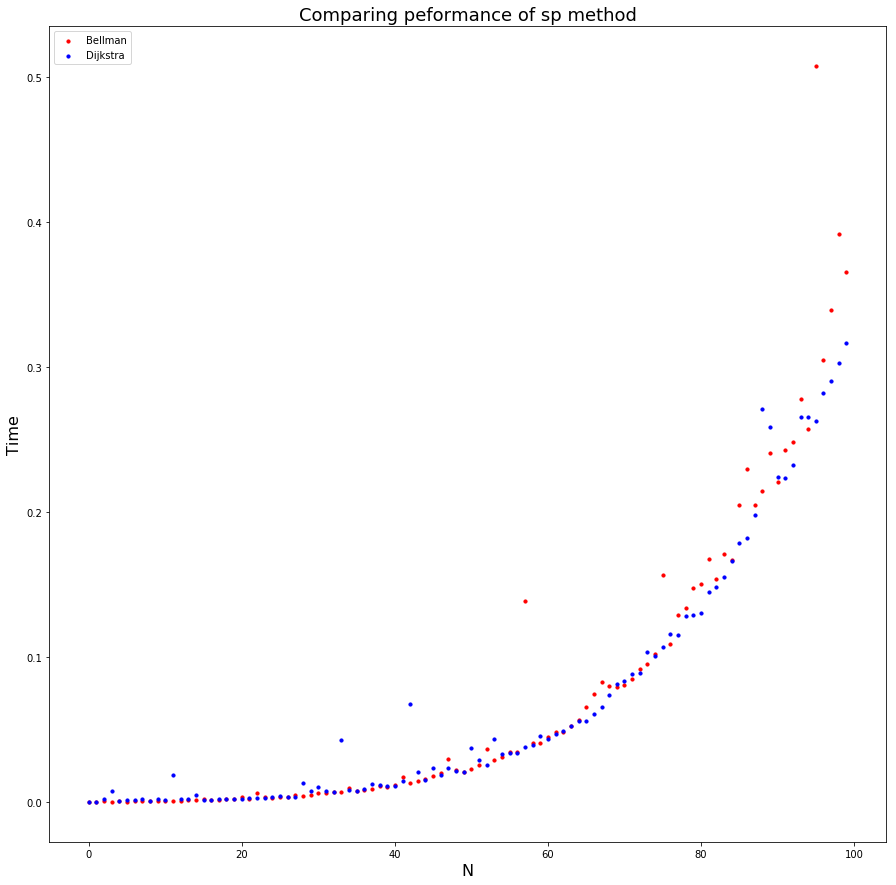

In [224]:
import pandas as pd
com_df = pd.DataFrame (efficiency_data)
fig, ax = plt.subplots(figsize=(15,15))

cols = {"Dijkstra": 'blue', "Bellman": 'red'}
for  mt, grouped in com_df.groupby('Method'):
    ax.scatter(grouped['N'], grouped['Time'], label=mt, c=cols[mt], s =10)
    
plt.xlabel('N', fontsize=16)
plt.ylabel('Time', fontsize=16)
plt.legend(loc=2)
plt.title("Comparing peformance of sp method",fontsize=18)